In [1]:
#save the code

arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file("02-basic_wandb.ipynb")
wandb.log_artifact(arti_code)

#wandb.save("2，kerasmodel_wandb_demo.ipynb")

In [2]:
import wandb
#save the code

arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file("02-basic_wandb.ipynb")
wandb.log_artifact(arti_code)

#wandb.save("2，kerasmodel_wandb_demo.ipynb")

In [3]:
#resume the run 
import wandb 
run = wandb.init(project='mnist_torchkeras', id=model.run_id, resume='must')

In [4]:
import torch

flag = torch.cuda.is_available()
if flag:
    print("CUDA可使用")
else:
    print("CUDA不可用")

# 获取GPU数量
ngpu = torch.cuda.device_count()
print("GPU数量：",ngpu)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))

In [5]:
import sys
from argparse import Namespace

sys.path.append('..')

config = Namespace(
    batch_size = 256,
    lr = 1e-3,
    dropout_p = 0.1,
)

In [6]:
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

In [7]:
import torch
import torchvision

ds_train = torchvision.datasets.MNIST(
    root="../datasets/mnist/",train=True,download=True,transform=transform
)
ds_val = torchvision.datasets.MNIST(
    root="../datasets/mnist/",train=False,download=True,transform=transform
)
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=config.batch_size, shuffle=True, num_workers=2
)
dl_val = torch.utils.data.DataLoader(
    ds_val, batch_size=config.batch_size, shuffle=False, num_workers=2
)

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#visual some samples
from matplotlib import pyplot as plt 

for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [9]:
import torch.nn as nn

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total

In [10]:
import torchkeras
import torch.nn as nn

def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

net = create_net(config)
model = torchkeras.KerasModel(
    net,
    loss_fn = nn.CrossEntropyLoss(),
    optimizer= torch.optim.Adam(net.parameters(),lr=0.001),
    metrics_dict = {"acc":Accuracy()},
)   

In [11]:

from torchkeras import summary
summary(model,input_data=features);

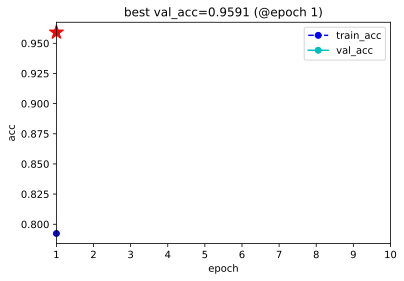

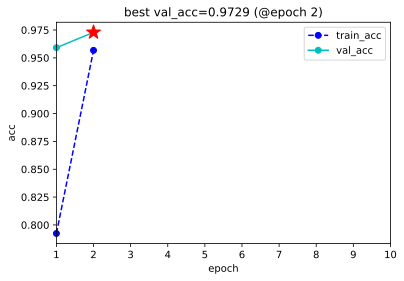

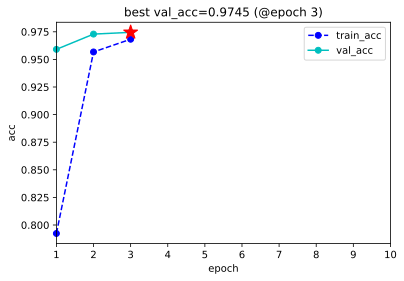

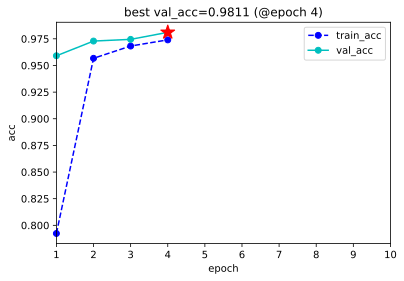

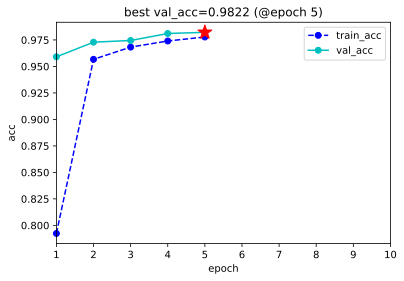

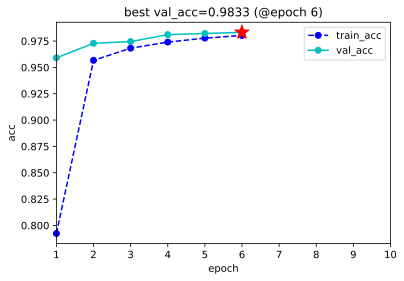

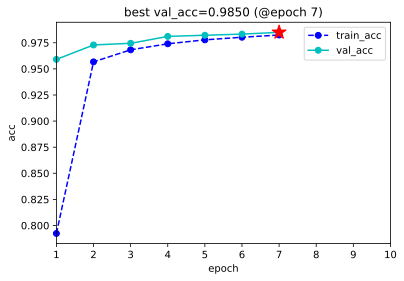

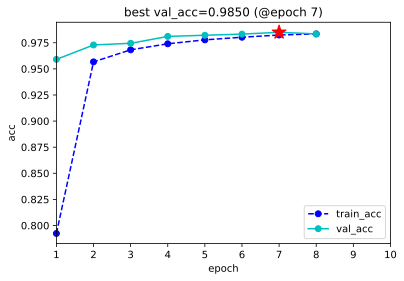

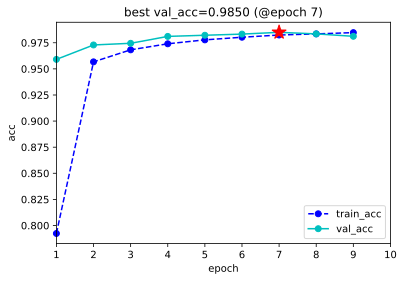

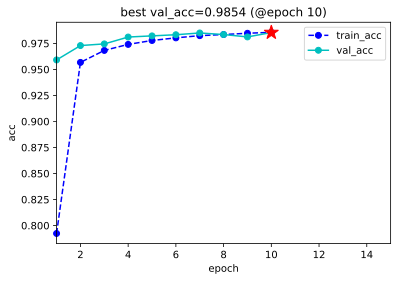

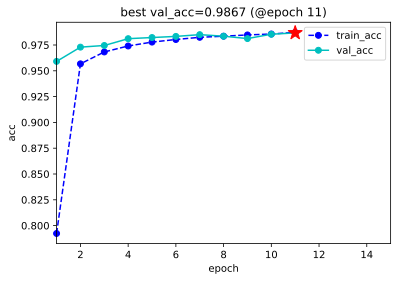

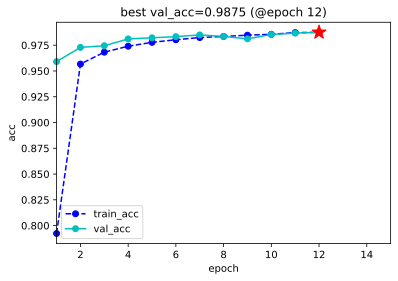

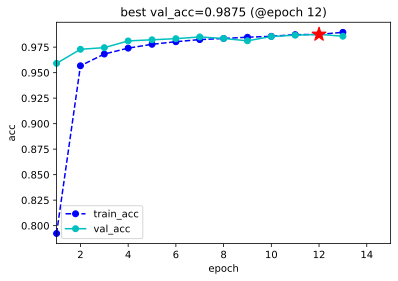

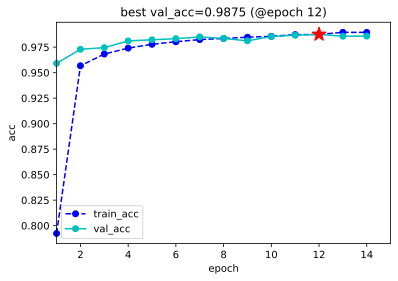

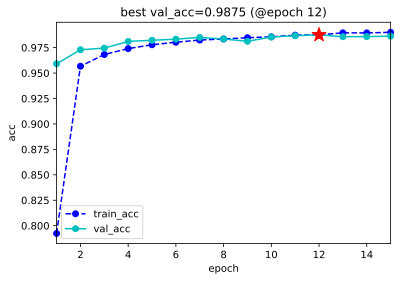

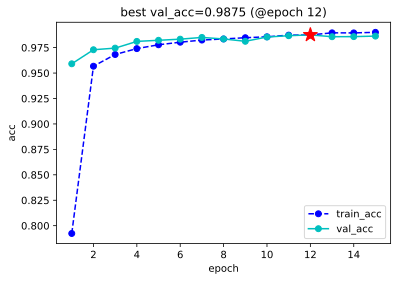

In [12]:
from torchkeras.kerascallbacks import WandbCallback

wandb_cb = WandbCallback(
    project='mnist_torchkeras',
    config=config,
    name=None,
    save_code=True,
    save_ckpt=True
)

dfhistory=model.fit(
    train_data=dl_train, 
    val_data=dl_val, 
    epochs=15, 
    patience=5, 
    monitor="val_acc",
    mode="max",
    ckpt_path='checkpoint.pt',
    callbacks = [wandb_cb]
)